# Initialize notebook

In [2]:
import wandb

In [3]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import DataLoader

In [4]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import sample_batch, summary, visualize_adj
from utils.train_utils.model_utils import Conv2dBlock, GatedConv2d, GatedConv2dBlock, GatedUpConv2dBlock

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


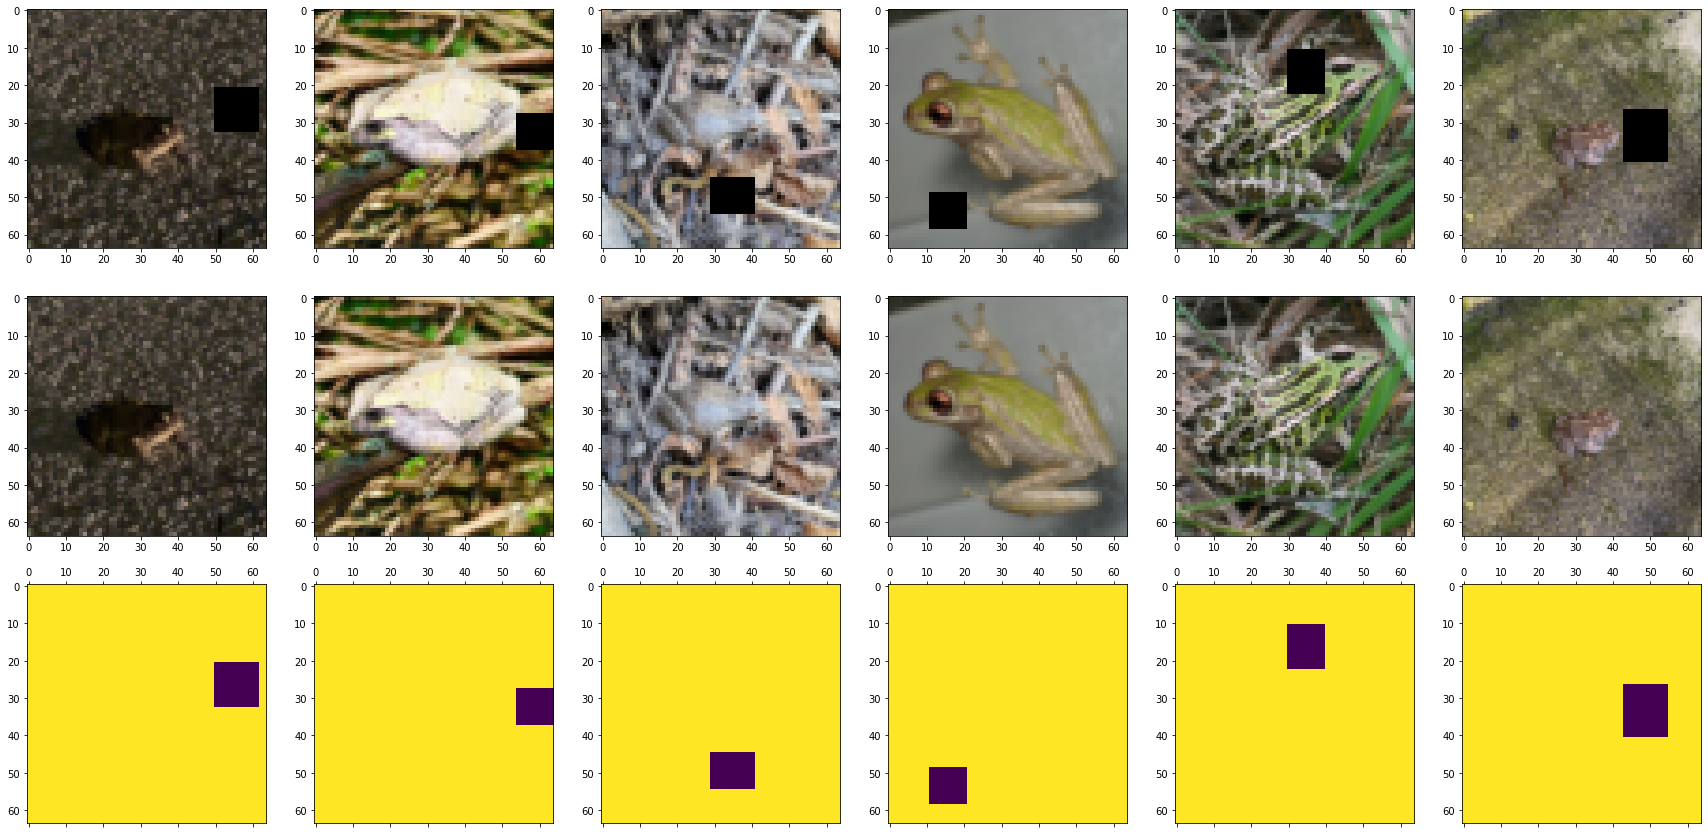

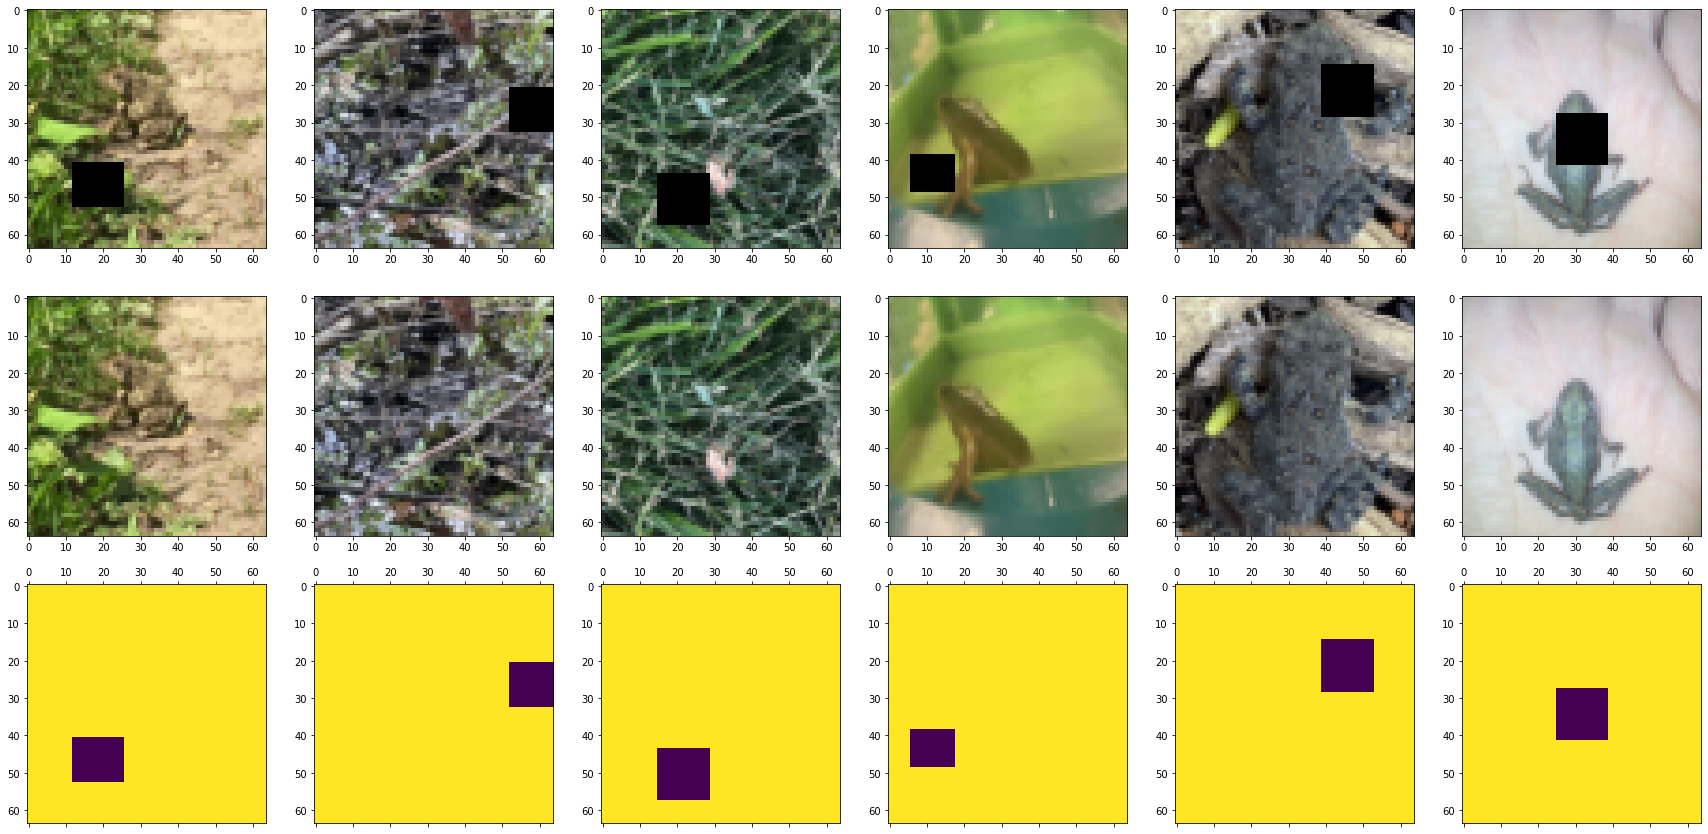

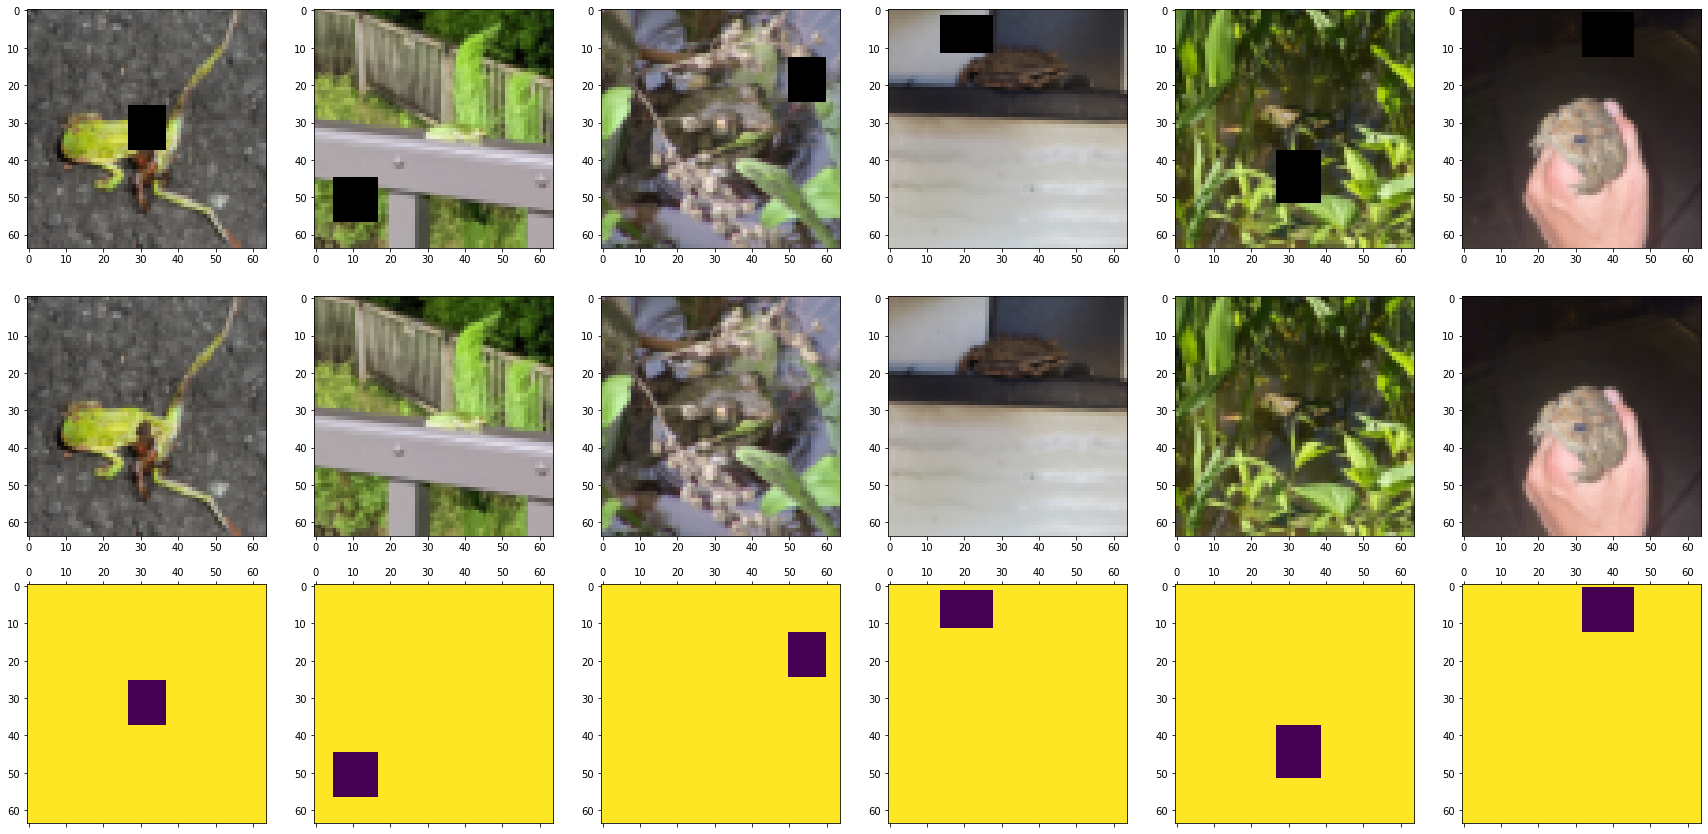

In [5]:
# sanity check 
sample_batch(train_dataset, sample_size = 6)
sample_batch(valid_dataset, sample_size = 6)
sample_batch(test_dataset, sample_size = 6)


# Introduction
This notebook aims to explore how the use of graphs to encode global information can improve capturing global context in image inpainting. The relevant references are:
1. How Powerful are Graph Neural Networks? (https://arxiv.org/abs/1810.00826)
2. Design Space for Graph Neural Networks (https://arxiv.org/abs/2011.08843)
3. Dynamic Attentive Graph Learning for Image Restoration (https://arxiv.org/abs/2109.06620)



# Model experiment


In [1]:
import torch_geometric as torch_g
import torch_geometric.nn as gnn


class GNNBlock(nn.Module):

    def __init__(self, in_channels, out_channels, heads, activation = nn.ReLU):

        super(GNNBlock, self).__init__()
        self.conv = gnn.GATv2Conv(in_channels, out_channels, heads)
        self.bn = gnn.BatchNorm(in_channels = out_channels)
        self.activation = activation()
        self.post1 = nn.Sequential(nn.Linear(out_channels, out_channels), activation())
        self.post2 = nn.Sequential(nn.Linear(out_channels, out_channels), activation())

    def forward(self, input_tensor, adj):
        # convert adj to sparse
        device = input_tensor.device
        edge_index = torch_g.utils.dense_to_sparse(adj).to(device)

        x = self.conv(input_tensor, edge_index)
        x = self.bn(x.permute(0,2,1)).permute(0,2,1) # bn takes channel first
        x = self.activation(x)
        x = self.post1(x)
        x = self.post2(x)
        
        return x

class GatedGraphConvModule(nn.Module):
    """
    This module implements GNN convolution on images using local, global and channel features to predict
    the adjacency tensor.
    """

    def __init__(self, channels, kernel_size, stride, padding, dilation, activation = nn.ReLU):

        super(GatedGraphConvModule, self).__init__()


        # incidence matrix
        self.feature_conv = GatedConv2dBlock(channels, channels, kernel_size = kernel_size, stride = stride, padding = padding, activation = activation)
        self.edge_conv = GatedConv2dBlock(channels, channels, kernel_size = kernel_size, stride = kernel_size, padding = padding, activation = activation)
        self.scaleconv = GatedConv2d(channels, channels, kernel_size = 1, stride = 1, padding = 1, dilation = 1)
        self.offsetconv = GatedConv2d(channels, channels, kernel_size = 1, stride = 1, padding = 1, dilation = 1)

        # graph conv
        self.gnn1 = GNNBlock(channels, channels, activation = activation)
        self.gnn2 = GNNBlock(channels, channels, activation = activation)
        self.gnn3 = GNNBlock(channels, channels, activation = activation)
        self.gnn4 = GNNBlock(channels, channels, activation = activation)


    def forward(self, input_tensor, return_adj = False,):

        # metadata
        b, c, h, w = input_tensor.shape
        
        # 1. compute features for edge prediction
        edge_features = self.edge_conv(input_tensor)

        # 2. compute adjacency matrix by dot product 
        scores = edge_features.view(b, c, h*w) # reshape and normalize
        scores = nn.functional.normalize(scores, p = 2, dim = 2) # normalize vector at each node
        scores = torch.bmm(scores.permute(0, 2, 1), scores) # (b x hw x c) x (b x c x hw) -> (b x hw x hw)
        adj_tensor = torch.sigmoid(scores)

        # 3. compute dampening factor by affine transformations of mean of edge features
        scale = self.edge_conv(edge_features)
        offset = self.offsetconv(edge_features)
        mean = scores.mean(dim = 1, keepdim = True) # (b x 1 x hw) mean of similarity scores as base
        adjustment = torch.relu(scale.view(b,1,h*w) * mean + offset.view(b,1,h*w)) # relu to keep everything positive

        # dampen
        adj_tensor = adj_tensor - adjustment

        # 4. graph conv
        x = input_tensor.view(b, c, h*w).permute(0, 2, 1)  # -> b x hw x c
        x = self.gnn1(x, adj_tensor) + x # -> b x hw x c
        x = self.gnn2(x, adj_tensor) + x # residual
        x = self.gnn3(x, adj_tensor) + x 
        x = self.gnn4(x, adj_tensor) + x 

        # 5. reshape back to image
        x = x.permute(0, 2, 1).view(b, c, h, w)

        if return_adj:
            return x, adj_tensor
            
        return x

    

NameError: name 'nn' is not defined

In [59]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(Generator, self).__init__()
        
        # same -> downsample 
        self.conv0 = GatedConv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # same -> downsample
        self.conv2 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 2 x same conv
        self.conv4 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv5 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # graph conv
        self.graphconv1 = GatedGraphConvModule(hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)

        # 4 x dilated conv
        self.conv6 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)
        self.conv7 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 4, dilation = 4, activation = activation)
        self.conv8 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 8, dilation = 8, activation = activation)
        self.conv9 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 16, dilation = 16, activation = activation)

        # 2 x same conv
        self.conv10 = GatedConv2dBlock(2 * hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv11 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # upsample -> same -> upsample -> same
        self.conv12 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv13 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv15 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')

        # for contrastive learning, 1x1 conv to compress feature map into 1 channel
        self.conv_feature = nn.Conv2d(hidden_dim, 1, kernel_size = 1, stride = 1, padding = 'same')

    def forward(self, input_tensor, return_adj = False):
        
        # downsample
        x = self.conv0(input_tensor)
        x = self.conv1(x)

        # downsample
        x = self.conv2(x)
        x = self.conv3(x)

        # middle preprocessing layers
        x = self.conv4(x) + x
        x = self.conv5(x) + x

        # graph conv
        g1, adj1 = self.graphconv1(x, return_adj = True)

        # dilated conv with residual skips
        x = self.conv6(x) + x
        x = self.conv7(x) + x
        x = self.conv8(x) + x
        x = self.conv9(x) + x

        # middle postprocessing layers
        x = self.conv10(torch.cat([x, g1], dim = 1))
        x = self.conv11(x) + x

        # upsample
        x = self.conv12(x)
        x = self.conv13(x)

        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        x = self.final(x)

        if return_adj:
            return x, adj1

        return x


class Discriminator(nn.Module):

    def __init__(self, input_dim, hidden_dim, input_shape, activation):

        super(Discriminator, self).__init__()

        # 5 layers down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # linear to predict classes
        LATENT_H = input_shape//(2**5)
        self.linear = nn.Linear(LATENT_H**2 * hidden_dim, 1)


    def forward(self, input_tensor):
        
        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # scores
        x = torch.flatten(x, start_dim = 1)
        x = self.linear(x)

        return x


# Training configuration

In [60]:
MODEL_PARAMS = {
    "description" : """
        Base structure same as the GLCIC model. 
        Gated convolutions replace all convolutions in the generator.
        Graph-based features are created at each downsampling, and concatenated to corresponding
        upsampling features. Gated masking in the graph module.""",
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator" : "/home/e/e0425222/CS4243-project/active_experiments/final/GraphGAN/ReplaceGlobal/generator/generator",
    "discriminator" : "/home/e/e0425222/CS4243-project/active_experiments/final/GraphGAN/ReplaceGlobal/discriminator/discriminator"
}

TRAINING_PARAMS = {
    "num_epochs" : 40,
    "batch_size" : 64, 
    "learning_rate": 1e-4,
    "alpha": 1,
    "schedule_every" : 5,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [61]:
# 1. initialize model
generator = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"])
discriminator = Discriminator(input_dim = 3, hidden_dim = MODEL_PARAMS["hidden_dim"], input_shape = 64, activation = MODEL_PARAMS["activation"])

summary(generator)
summary(discriminator)

# 2. device
parallel = True
device = 'cuda:0'  
devices = [0,1,2,3]

if not parallel:
    generator1 = generator.to(device)
    discriminator = discriminator.to(device)
else:
    generator1 = nn.DataParallel(generator, device_ids = devices)
    discriminator = nn.DataParallel(discriminator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'none').sum()/(1-mask).sum()
discriminator_loss_function = nn.functional.binary_cross_entropy_with_logits

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}


# 5. initialize optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator_model"] = generator
TRAINING_PARAMS["generator_optimizer"] = generator_optimizer
TRAINING_PARAMS["generator_scheduler"] = generator_scheduler
TRAINING_PARAMS["discriminator_model"] = discriminator
TRAINING_PARAMS["discriminator_optimizer"] = discriminator_optimizer
TRAINING_PARAMS["discriminator_scheduler"] = discriminator_scheduler
TRAINING_PARAMS["discriminator_loss_function"] = discriminator_loss_function
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function



model has 1.41338 million parameters
model has 0.150401 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Initialize logging

In [62]:
wandb.init(project="final", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator, discriminator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


[]

# Train

## Train functions

In [63]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    DISCRIMINATOR_LOSS_FUNCTION = training_params["discriminator_loss_function"]

    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]
    DISCRIMINATOR_OPTIMIZER = training_params["discriminator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]
    ALPHA = training_params["alpha"]

    # models
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_discriminator"] = 0.0
    running_results["loss_generator"] = 0.0
    running_results["loss_generator_r"] = 0.0
    running_results["loss_generator_adv"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)


            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # ===== FORWARD PASS =====

            # 1. train discriminator
            DISCRIMINATOR_OPTIMIZER.zero_grad()
            
            # 1.1 generate images
            input_batched.requires_grad_()
            output_batched = generator(input_batched)

            # 1.2 splice with ground truth
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 1.3 feed into discriminator
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            label_fake = torch.zeros(BATCH_SIZE, 1).to(device)

            pred_real = discriminator(ground_truth_batched)
            loss_real = DISCRIMINATOR_LOSS_FUNCTION(pred_real, label_real)

            pred_fake = discriminator(spliced_batched.detach())
            loss_fake = DISCRIMINATOR_LOSS_FUNCTION(pred_fake, label_fake)
            loss_d = ALPHA * (loss_real + loss_fake)
            loss_d.backward()
            DISCRIMINATOR_OPTIMIZER.step()

            # 2. train generator (reconstruction, adverserial)
            GENERATOR_OPTIMIZER.zero_grad()

            # 2.1 forward pass by generator to produce images, splice them
            output_batched, adj1 = generator(input_batched, return_adj = True)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 2.2 reconstruction loss
            loss_g_reconstruction = RECONSTRUCTION_LOSS(output_batched, ground_truth_batched, mask_batched)

            # 2.3 adverserial loss
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            pred_adverserial = discriminator(spliced_batched)
            loss_g_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred_adverserial, label_real) # want it to classify all as real

            # 2.5 backprop
            loss_g = loss_g_reconstruction + ALPHA * loss_g_adverserial
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator"] += loss_g.detach().item()
            running_results["loss_generator_r"] += loss_g_reconstruction.detach().item()
            running_results["loss_generator_adv"] += loss_g_adverserial.detach().item()
            running_results["loss_discriminator"] += loss_d.detach().item()

            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                b, hw, hw = adj1.shape
                adj1 = visualize_adj(adj1, b, int(hw**0.5), int(hw**0.5))
                adj1_array = torchvision.utils.make_grid(adj1[:SAMPLE_SIZE].unsqueeze(1), nrow = SAMPLE_SIZE)
                adj1_images = wandb.Image(
                    adj1_array, 
                    caption = "First adjacency tensor")


                # log images and some metadata
                wandb.log( {
                    "generator_train_images" : images,
                    "adj1_images" : adj1_images,
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],
                    "lr_discriminator" : DISCRIMINATOR_OPTIMIZER.param_groups[0]['lr']

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        
            # ===== HOUSEKEEPING =====
            del loss_g
            del loss_d
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [64]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator = training_params["generator_model"].to(device).eval()

    # constants
    BATCH_SIZE = training_params["batch_size"]
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, _ in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # log images and some metadata
                wandb.log( {
                    "generator_val_images" : images,
                })

                # log all metrics
                wandb.log(
                    {f"val_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [65]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    DISCRIMINATOR_SCHEDULER = training_params["discriminator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_discriminator"] = []
    train_results["loss_generator"] = []
    train_results["loss_generator_r"] = []
    train_results["loss_generator_adv"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if DISCRIMINATOR_SCHEDULER is not None:
            DISCRIMINATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['discriminator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(discriminator.state_dict(), SAVE)  

        print("Saved models!")

    return train_results, eval_results

## Train

In [66]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 0, log_wandb = True)


===== Epoch: 1 ===== 
155/156: Peak SnR (Whole): 29.72742778408912   L2 loss (Whole): 0.001567519570685803   L2 loss (Mask): 0.13491127668849884   L1 loss (Whole): 0.005062991980042669   L1 loss (Mask): 0.43639096560016755   LPIPS (Whole): 0.05156567007783921   loss_discriminator: 1.398107216435094   loss_generator: 0.8330057636384041   loss_generator_r: 0.13491127668849884   loss_generator_adv: 0.6980944891129771     
15/15: Peak SnR (Whole): 31.3068790435791   L2 loss (Whole): 0.000741231922681133   L2 loss (Mask): 0.06456733867526054   L1 loss (Whole): 0.00388144690853854   L1 loss (Mask): 0.33804481029510497   LPIPS (Whole): 0.038941605885823564      
Completed epoch 1! Took 2.725223886966705 min
Saved models!

===== Epoch: 2 ===== 
155/156: Peak SnR (Whole): 31.544744208551222   L2 loss (Whole): 0.000703610316850245   L2 loss (Mask): 0.06114510752020344   L1 loss (Whole): 0.0037839770692610934   L1 loss (Mask): 0.3288590056280936   LPIPS (Whole): 0.03877358864392004   loss_discri

({'Peak SnR (Whole)': [29.732579573606834,
   31.544730675526154,
   32.09900646943312,
   32.21820074472672,
   32.283415818825745,
   32.13065951909774,
   32.2980548907549,
   32.11984825134277,
   32.19421251003559,
   32.25584461750128,
   32.430589602543755,
   32.41698129360493,
   32.4003367790809,
   32.46291142243605,
   32.47654203268198,
   32.49815564277844,
   32.516608727283966,
   32.448309238140396,
   32.50934677857619,
   32.435322761535645,
   32.50927760050847,
   32.524374864040276,
   32.55882035768949,
   32.51723276040493,
   32.45816686825874,
   32.53325456228011,
   32.55714900677021,
   32.54462992839324,
   32.523071790352844,
   32.48782675082867,
   32.505995004605026,
   32.46515047855866,
   32.574884170140976,
   32.5479333950923,
   32.54572810882177,
   32.497644326625725,
   32.50429086196117,
   32.46744511677669,
   32.49919015933306,
   32.50637868734506],
  'L2 loss (Whole)': [0.0015631437399394761,
   0.0007035585988957721,
   0.00061828691701

In [67]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 40, log_wandb = True)


===== Epoch: 41 ===== 
155/156: Peak SnR (Whole): 32.53568398260301   L2 loss (Whole): 0.000557784107889259   L2 loss (Mask): 0.04838901635619902   L1 loss (Whole): 0.003194970347648186   L1 loss (Mask): 0.2771965365256033   LPIPS (Whole): 0.024599608490543982   loss_discriminator: 1.3855220602404688   loss_generator: 0.7441290740043887   loss_generator_r: 0.04838901635619902   loss_generator_adv: 0.6957400575760873       
15/15: Peak SnR (Whole): 32.774020767211915   L2 loss (Whole): 0.0005283354587542514   L2 loss (Mask): 0.04590925599137942   L1 loss (Whole): 0.0030728602626671395   L1 loss (Mask): 0.2671710789203644   LPIPS (Whole): 0.024126319338877995    
Completed epoch 41! Took 2.6913193583488466 min
Saved models!

===== Epoch: 42 ===== 
155/156: Peak SnR (Whole): 32.44588280954669   L2 loss (Whole): 0.000569431054698784   L2 loss (Mask): 0.04944094597331939   L1 loss (Whole): 0.0032297797471044524   L1 loss (Mask): 0.2804156687951857   LPIPS (Whole): 0.024615391992753553   lo

({'Peak SnR (Whole)': [32.53442152952537,
   32.44534392234607,
   32.55634722342858,
   32.46756359247061,
   32.57444650698931,
   32.48824339646559,
   32.51715184480716,
   32.500007776113655,
   32.50950033236773,
   32.4681934943566,
   32.45872155213967,
   32.56994606898381,
   32.52507928701547,
   32.53680119147668,
   32.468754609425865,
   32.4907173254551,
   32.54284873375526,
   32.500321155939346,
   32.470024487911125,
   32.49585077090141,
   32.46187100043664,
   32.51044845581055,
   32.56886670528314,
   32.48093777436476,
   32.514966500111115,
   32.44205237657596,
   32.51185036928226,
   32.589883877680855,
   32.460367765182106,
   32.490825005066704,
   32.48658451667199,
   32.4599536382235,
   32.43807380627363,
   32.45920847623776,
   32.507349588932136,
   32.512602048042496,
   32.521524673853165,
   32.434548426897095,
   32.52980883916219,
   32.49558360760029],
  'L2 loss (Whole)': [0.0005579496833095804,
   0.0005694730142026972,
   0.00055534203028

In [68]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)

wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
